# The comparison with commuterverses model and mean-filed approach

This notebook compares the commuterverses and mean-field approach of geographical compartment model. Although, both methods can apply arbitrary model, we use SIR model here.
The dynamical equations are given as

\begin{align}
\dot{S_{in}}	    &=-\lambda_{in}(t)S_{in}+\sigma_{in},\\
\dot{I}_{in}	    &=\lambda_{in}(t)S_{in}-\gamma_{I}I_{in},\\
\dot{R}_{in}	    &=\gamma_{I}I_{in}\\
\end{align}


In [1]:
import sys
import pprint
pprint.pprint(sys.path)

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/hidekb/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/UNKNOWN-0.0.0-py3.6-linux-x86_64.egg',
 '/usr/local/lib/python3.6/dist-packages/pyross-1.2.9-py3.6-linux-x86_64.egg',
 '/usr/local/lib/python3.6/dist-packages/dill-0.3.2-py3.6.egg',
 '/usr/local/lib/python3.6/dist-packages/nlopt-2.6.2-py3.6-linux-x86_64.egg',
 '/usr/local/lib/python3.6/dist-packages/sympy-1.6.2-py3.6.egg',
 '/usr/local/lib/python3.6/dist-packages/cma-3.0.3-py3.6.egg',
 '/usr/local/lib/python3.6/dist-packages/mpmath-1.1.0-py3.6.egg',
 '/usr/local/lib/python3.6/dist-packages/PyRossGeo-1.0.4-py3.6-linux-x86_64.egg',
 '/usr/lib/python3/dist-packages',
 '/home/hidekb/.local/lib/python3.6/site-packages/IPython/extensions',
 '/home/hidekb/.ipython']


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

Firstly, the commuterverses model will be calculated.

# Generate the configuration files

### Define model

In [3]:
model = {
    "settings" : {
        "classes" : ["S", "I", "R"],
        #"stochastic_threshold_from_below" : [1000, 1000, 1000],
        #"stochastic_threshold_from_above" : [500, 500, 500],
        "contact_scaling" : "powerlaw",
        "contact_scaling_parameters" : [0, 1.0, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-betaI"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gammaI"] ],
        "infection" : [ ["I", "betaI"] ]
    },

    "R" : {
        "linear"    : [ ["I", "gammaI"] ],
        "infection" : []
    }
}

model_classes = model['settings']['classes']
model_dim = len(model_classes)

### Configuration generation parameters

Here we define some parameters with which all the configuration files will be generated. Edit these if you want to change the simulation.

In [4]:
sim_config_path = 'london_simulation'

min_num_moving = 12 # Remove all commuting edges where less than `min_num_moving` are moving

# Decide which classes are allowed to commute
allow_class = [
    ('S', True),
    ('I', True),
    ('R', True),
]

s_num=100
# Decide where to seed with infecteds
seed_pop = [
    (0, 1, 'I', s_num),      # Home, age group, model class, seed quantity
    (10, 2, 'I', s_num),      
    (23, 0, 'I', s_num),     
    (622, 4, 'I', s_num),
    (232, 4, 'I', s_num)
]

# Node parameters

n_betaI = 0.01#/1440.0
n_gammaI = 0.1/3.0

# Cnode parameters

cn_betaI = n_betaI
cn_gammaI = n_gammaI

# Time steps

t_start = 0
t_end = 24*60*100

_, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  1*60),
    (7*60,  2),
    (10*60, 2*60),
    (17*60, 2),
    (19*60, 2*60)
], end_time=24*60)

### Format the commuting network

In [5]:
cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path)

#### Set which classes are allowed to commute

# Drop the current allow_O columns
cn = cn.iloc[:,:10]

# Set allow settings
for O, allow_O in allow_class:
    cn[ "Allow %s" % O ] = 1 if allow_O else 0
    
# Allow people to return home
cn.loc[ cn['Home'] == cn['To'],"Allow %s" % allow_class[0][0]:] = 1

#### Remove commuting edges where fewer than `min_num_moving` people are commuting

delete_rows = []

for i, row in cn.loc[ cn['Home'] == cn['From'] ].iterrows():
    if row['# to move'] < min_num_moving:
        delete_rows.append(i)
        delete_rows.append(i+1) # Delete the returning commuting edge as well

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

cn.loc[cn['ct1'] == cn['ct2'], 'ct2'] += 0.1

cn.head()

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow I,Allow R
4,0,0,180,5,13,-1,8.935442,9.000000,9.000000,9.166667,1,1,1
5,0,180,0,5,-1,1,17.000000,17.064558,17.064558,17.231224,1,1,1
16,0,0,185,5,19,-1,8.969720,9.000000,9.000000,9.166667,1,1,1
17,0,185,0,5,-1,1,17.000000,17.030280,17.030280,17.196947,1,1,1
18,0,0,185,6,17,-1,8.969720,9.000000,9.000000,9.166667,1,1,1


### Populate the network

Our `node_populations.csv` currently only has the total population for each age group at each node. In order to use it for the simulation, we must populate it with the model classes, as well as seed some infections.

In [6]:
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
tot_pop.head()

,Home,Location,N(0-4),N(5-10),N(11-15),N(16-24),N(25-34),N(35-49),N(50-64),N(65-74),N(75+)
0,0,0,414,601,250,910,1333,1624,1695,839,654
1,1,1,636,904,436,765,1057,1476,1036,432,550
2,2,2,845,1067,503,1094,1734,2261,1713,662,585
3,3,3,441,534,265,796,930,1113,1145,432,566
4,4,4,934,1189,562,1078,1517,2116,1404,485,397


### Setting the node and cnode parameters

We need to add rows giving the model parameters in `node_parameters.csv` and `cnode_parameters.csv`, which currently only has the areas of each geographical node:

In [7]:
# Create all model classes, and set everyone to be susceptible

npop = pd.DataFrame()
npop['Home'] = tot_pop['Home']
npop['Location'] = tot_pop['Location']

for _cn, _cd in tot_pop.iloc[:,2:].iteritems():
    for O in model['settings']['classes']:
        npop["%s%s" % (O, _cn[1:])] = 0
        
    npop["%s%s" % ("S", _cn[1:])] = _cd
    
# Seed with infecteds

for home, age, O, seed_quantity in seed_pop:
    row_i = npop[npop['Home'] == home].index[0]
    col_i = 2 + age*model_dim
    S = npop.iloc[row_i,col_i]
    npop.iloc[row_i, col_i + model_classes.index('I')] = seed_quantity
    npop.iloc[row_i, col_i] -= seed_quantity

In [8]:
nparam = pd.read_csv('london_simulation/node_parameters.csv')
cnparam = pd.read_csv('london_simulation/cnode_parameters.csv')
nparam.head()
cnparam.head()

,Home,From,To,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
0,ALL,ALL,ALL,ALL,1,NaN,NaN,NaN,NaN,NaN


In [9]:
cnparam['betaI'] = cn_betaI
cnparam['gammaI'] = cn_gammaI

nparam = nparam.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'Age' : 'ALL',
    'betaI' : n_betaI,
    'gammaI' : n_gammaI,
}, ignore_index=True)

nparam.iloc[-2:-1,:]

,Home,Location,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
982,982,982,ALL,1.986049,NaN,NaN,NaN,NaN,NaN


### Contact matrices

Define the contact matrices

In [10]:
C_home = np.array( [
    [5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28,4.23],
    [4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28],
    [4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33],
    [4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4],
    [4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48],
    [4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58],
    [4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69],
    [4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83],
    [4.23,4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0],
] )
    
C_school = np.array( [
    [8.0,7.83,7.69,0.25,0.19,0.15,0.12,0.1,0.09],
    [7.83,8.0,7.83,0.26,0.19,0.15,0.12,0.1,0.09],
    [7.69,7.83,8.0,0.26,0.19,0.15,0.12,0.11,0.09],
    [0.25,0.26,0.26,0.27,0.2,0.15,0.13,0.11,0.09],
    [0.19,0.19,0.19,0.2,0.2,0.16,0.13,0.11,0.09],
    [0.15,0.15,0.15,0.15,0.16,0.16,0.13,0.11,0.09],
    [0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.11,0.1],
    [0.1,0.1,0.11,0.11,0.11,0.11,0.11,0.11,0.1],
    [0.09,0.09,0.09,0.09,0.09,0.09,0.1,0.1,0.1]
])

C_work = np.array( [
    [0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07],
    [0.07,0.09,0.08,0.08,0.08,0.08,0.08,0.08,0.08],
    [0.07,0.08,0.1,0.1,0.09,0.09,0.09,0.09,0.09],
    [0.07,0.08,0.1,0.12,0.12,0.11,0.11,0.11,0.11],
    [0.07,0.08,0.09,0.12,0.15,0.15,0.14,0.14,0.14],
    [0.07,0.08,0.09,0.11,0.15,0.2,0.19,0.19,0.19],
    [0.07,0.08,0.09,0.11,0.14,0.19,6.0,5.83,5.69],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.83,6.0,5.83],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.69,5.83,6.0]
])

C_transport = np.array( [
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0]
])

contact_matrices = {
    'C' : (C_home + C_school + C_work)/1440.0,
    'C_commute' : C_transport/1440.0
}

In [11]:
ncm = pd.DataFrame(columns=['Home', 'Location'] + model['settings']['classes'])

ncm = ncm.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'I' : 'C'
}, ignore_index=True)

In [12]:
cncm = pd.DataFrame(columns=['Home', 'From', 'To'] + model['settings']['classes'])

cncm = cncm.append({
    'Home' : 'ALL',
    'From' : 'ALL',
    'To' : 'ALL',
    'I' : 'C_commute'
    #'I' : 'C'
}, ignore_index=True)

## Run simulation

In [13]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize(
    model_dat = model,
    commuter_networks_dat = cn,
    node_populations_dat = npop,
    node_parameters_dat = nparam,
    cnode_parameters_dat = cnparam,
    contact_matrices_dat = contact_matrices,
    node_cmatrices_dat = ncm,
    cnode_cmatrices_dat = cncm
)

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=len(dts), steps_per_print=len(dts))

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

Stochastic thresholds not defined. Will simulate deterministically.
Step 0 out of 16400
Step 164 out of 16400
Step 328 out of 16400
Step 492 out of 16400
Step 656 out of 16400
Step 820 out of 16400
Step 984 out of 16400
Step 1148 out of 16400
Step 1312 out of 16400
Step 1476 out of 16400
Step 1640 out of 16400
Step 1804 out of 16400
Step 1968 out of 16400
Step 2132 out of 16400
Step 2296 out of 16400
Step 2460 out of 16400
Step 2624 out of 16400
Step 2788 out of 16400
Step 2952 out of 16400
Step 3116 out of 16400
Step 3280 out of 16400
Step 3444 out of 16400
Step 3608 out of 16400
Step 3772 out of 16400
Step 3936 out of 16400
Step 4100 out of 16400
Step 4264 out of 16400
Step 4428 out of 16400
Step 4592 out of 16400
Step 4756 out of 16400
Step 4920 out of 16400
Step 5084 out of 16400
Step 5248 out of 16400
Step 5412 out of 16400
Step 5576 out of 16400
Step 5740 out of 16400
Step 5904 out of 16400
Step 6068 out of 16400
Step 6232 out of 16400
Step 6396 out of 16400
Step 6560 out of 1640

## Plot the result

Plot the evolution of the whole network

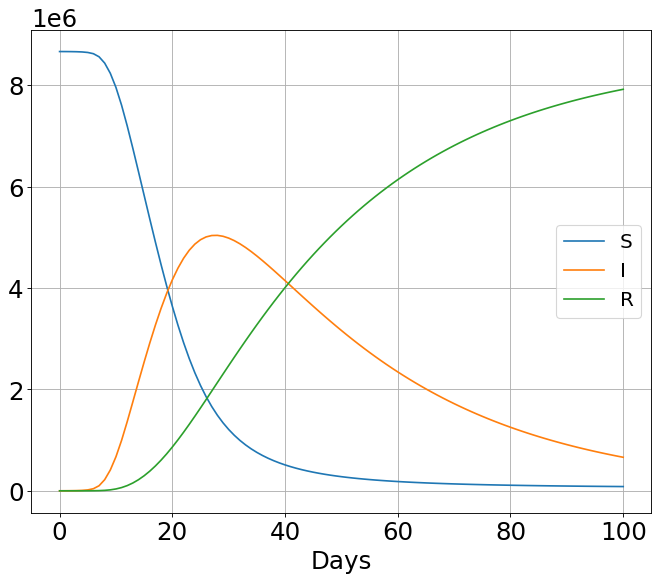

In [14]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

S = np.sum(network_data[:,:,0], axis=1)
I = np.sum(network_data[:,:,1], axis=1)
R = np.sum(network_data[:,:,2], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

#plt.legend(loc='upper right', fontsize=12)
plt.legend(fontsize=18); plt.grid() 
plt.xlabel('Days')

f_data = open('network-SIR-CMV.txt', mode='w')
for i in range(len(ts_days)):
    f_data.write(str(ts_days[i]) + ' ' + str(S[i]) + ' ' + str(I[i]) + ' ' + str(R[i]) + '\n')
f_data.close()

Next, we perform the mean-filed model.
The key idea of mean-field model is to note that the rate of infection of a susceptible individual in age group `i` at the node `n` is given as

\begin{align}
\lambda_{in}(t)=\lambda^0_{in}(t)=\beta\sum_{j=1}^{M}C_{ij}\frac{I_{jn}}{N^{H}_{jn}},
\end{align}


Commute can then be modeled by changing this to


\begin{align}
\lambda_{in}^{T}(t)=\beta r^{T}\sum_{j=1}^{M}\sum_{m=1}^{N_{d}} \sum_{<k,l>} C_{ij} \frac{D_{j,kl}}{N^{H}_{j,l}} \frac{I_{jl}}{N^{T}_{j,mn}} \frac{D_{i,mn}}{N^{H}_{i,n}},
\end{align}


while workplace interaction can be modeled as


\begin{align}
\lambda_{in}^{W}(t)=\beta r^{W}\sum_{j=1}^{M}\sum_{m,k=1}^{N_{d}} C_{ij} \frac{D_{j,mk}}{N^{H}_{jk}} \frac{I_{jk}}{N^{W}_{jm}}  \frac{D_{i,mn}}{N^{H}_{in}}.
\end{align}

The derivation of all equations is wrriten in [the documentation](https://github.com/lukastk/PyRossGeo/tree/master/docs/mft-model.pdf).
The simulation then runs by choosing appropriate $\lambda$ as a function of time. The constants $r_T$ and $r_W$ control the strength of interactions. In this model, we assume that each route between the nodes connectsneighbour nodes only.

The defiintion of the variables are in following.
$D_{i,nm}$ is the number of people working at node `n` and livingin `m` in the age group `i`, $N^{H}_{in}=\sum_{m} D_{i,mn}$ is the total number of residence in node `n` and $N^{W}_{in}=\sum_{m} D_{i,nm}$ is the total number of people working at node `n`.
$N_{i,nm}^{T}$ is the effective number of the commuter in the age group `i` using the route between `n` and `m`:

\begin{align}
N^{T}_{i,nm}=\sum_{<kl>}R_{i,kl}\frac{d_{kl}}{d_{nm}},
\end{align}

where $<kl>$ indicate summation of all pair of neighbour node $k$ and $l$ included in the shortest path between node 
`n` and `m` and $d_{nm}$ is the distance between node `n` and `m` along the shortest path. $R_{i,nm}=\sum_{<kl>}D_{i,kl}$ is the number of the commuter in the age group `i` using the route between the neighbor node `n` and `m`. The node `n` and `m` are included in the shortest path between node pair 
$(k,l)$ took up all combinations satisfying the conditions.
Hence, we only need $D_{i,nm}$ and $d_{nm}$ in order to construct this network model. $D_{i,nm}$ can be obtained census datasets and $d_{nm}$ can be determined by the geographical locations. For the calculation of London including 983 nodes, $D_{i,nm}$ and $d_{nm}$ are stored in census.txt and distnaces.txt, respectively.

In [15]:
import numpy as np
import pyrossgeo
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import gc

## Model Define

In [16]:
model_def = {
    "settings" : {
        #"classes" : ["S", "E", "A", "I", "R"],
        "classes" : ["S", "I"],
        #"stochastic_threshold_from_below" : [1000, 1000, 1000, 1000],
        #"stochastic_threshold_from_above" : [500, 500, 500, 500],
        "contact_scaling" : "powerlaw",
        "contact_scaling_parameters" : [0, 1.0, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gI"] ],
        "infection" : [ ["I", "beta"] ] 
    }#,

    #"R" : {
    #    "linear"    : [ ["I", "gI"] ],
    #    "infection" : []
    #}
}

Loading $D_{i,nm}$ from csv files.

In [17]:
M = 9 #Aged Group

sim_config_path = 'london_simulation'
#sim_config_path = 'london_simulation'
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
#tot_pop.head()
CSV_Nh = tot_pop.values
Nd = len(tot_pop) # The number of nodes

Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
for i in range(Nd):
    for alp in range(M):
        Nh[alp,i] = CSV_Nh[i,alp + 2]

cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path, usecols=["Home", "From", "To", "Age", "# to move"])
#cn.head()
CSV_Dnm = cn.values

ii16 = np.iinfo(np.uint16)
Dnm_Max = np.amax(CSV_Dnm[:,4])
print('Max Dnm', Dnm_Max)
if ii16.max < Dnm_Max:
      print('Dnm is too large to calculate.')

census_matrix = np.zeros((M, Nd, Nd), dtype=np.uint16)
for i in range(len(CSV_Dnm)):
    if CSV_Dnm[i,0] == CSV_Dnm[i,1]:
        census_matrix[CSV_Dnm[i,3], CSV_Dnm[i,2], CSV_Dnm[i,0]] = CSV_Dnm[i,4]
        
for alp in range(M):
    for i in range(Nd): # Home node
        census_matrix[alp,i,i] = Nh[alp,i] - np.sum(census_matrix[alp,:,i])
        
df = pd.read_csv('area.csv')
Area = df.values[:,1]/10**6
        
del tot_pop
del CSV_Nh
del cn
del CSV_Dnm
del df
gc.collect()

Max Dnm 1064


6

Loading $d_{nm}$ from distances.txt

In [18]:
#distances=np.ones((Nd, Nd))
    
#Make Total
#for i in range(Nd):
#    for j in range(Nd):
#        #for alp in range(M):
#        census_matrix[M,i,j] = np.sum(census_matrix[:,i,j])
                
Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
Nw = np.zeros((M + 1,Nd)) # The number of people working in specific node.
for alp in range(M):
    for i in range(Nd):
        #Nh[alp,i] = 0.
        #Nw[alp,i] = 0.
        #for j in range(Nd):
        Nh[alp,i] = np.sum(census_matrix[alp,:,i])
        Nw[alp,i] = np.sum(census_matrix[alp,i,:])
#for alp in range(M):
for i in range(Nd):
    Nh[M,i] = np.sum(Nh[:,i]) ## N^{H}_{i} residence in Node i
    Nw[M,i] = np.sum(Nw[:,i]) ## N^{W}_{i} working in Node i
        
# set the matarix D_{nm}
Dnm = census_matrix #.copy()

# set the matarix d_{nm}
dnm = 1#distances #.copy()

max_wid = np.argsort(Nw[M])[Nd- 1]
print("Maxmimum City at Working", max_wid, Nh[M,max_wid], Nw[M,max_wid])
max_rid = np.argsort(Nh[M])[Nd- 1]
print("Maxmimum City of Residence", max_rid, Nh[M,max_rid], Nw[M,max_rid])
#sorted_Nh = np.argsort(Nh[M])
#for i in range(50):
#    print('No.', i, sorted_Nh[Nd - 1 -i], Nh[M,sorted_Nh[Nd - 1 -i]])

Maxmimum City at Working 0 8320.0 247971.0
Maxmimum City of Residence 701 24719.0 24436.0


We use same $C_{ij}$, model parameters and the initial state.

In [19]:
# set the contact structure
CH = C_home + C_school + C_work
CT = C_transport
CW = C_home + C_school + C_work
        
# parameters, which should be inffered
beta  = 0.01/24.0       # infection rate
gI    = 0.1/3.0/24.0    # recovery rate of infectives 
rW    = 1.0             # the intercation controle in WORK
rT    = 1.0             # the intercation controle in TRANS

cutoff    = 11 # We ignore D_{i,nm}, when It is less than the vule of cutoff.
trv_restriction = 0.0   # travel restriction: 1.0 means everyone stay home

max_wid = np.argsort(Nw[M])[Nd- 1]
#print("Maxmimum City at Working", max_wid)
max_rid = np.argsort(Nh[M])[Nd- 1]
#print("Maxmimum City of Residence", max_rid)
min_wid = np.argsort(Nw[M])[0]
#print("Minimum City at Working", min_wid)
min_rid = np.argsort(Nh[M])[0]
#print("Minimum City of Residence", min_rid)

M1 = Nd*M
I_0 = np.zeros((M1))

#seed_pop = [
#    (0, 1, 'E', 100),      # Home, age group, model class, seed quantity
#    (10, 2, 'E', 100),      
#    (23, 0, 'E', 100),     
#    (622, 4, 'E', 100),
#    (232, 4, 'E', 100)
#]
s_num = 100
I_0[1*Nd + 0]   += s_num
I_0[2*Nd + 10]  += s_num
I_0[0*Nd + 23]  += s_num
I_0[4*Nd + 622] += s_num
I_0[4*Nd + 232] += s_num

#Is_0[min_wid] += 10
R_0 = np.zeros((M1))
N_0 = np.zeros((M1))
for alp in range(M):
    for i in range(Nd):
        N_0[Nd*alp + i] = Nh[alp,i]
S_0  = N_0 - (I_0 + R_0)
print("Maximum R", Nh[M,max_rid], Nw[M,max_rid])
print("Maximum w", Nh[M,max_wid], Nw[M,max_wid])
print("Minimum R", Nh[M,min_rid], Nw[M,min_rid])
print("Minimum w", Nh[M,min_wid], Nw[M,min_wid])

# the contact matrix
def contactMatrix(t):
    t_p_24 = t%24
    if t_p_24 < 8.0 or t_p_24 > 18.0:
        return CH
    elif t_p_24 > 9.0 and t_p_24 < 17.0:
        return CW
    else:
        return CT

# set the matarix D_{nm}
#Dnm = census_matrix.copy()

# set the matarix d_{nm}
#dnm = distances.copy()

# instantiate model
geographical_model = 'RapidTransport'
#geographical_model = 'SpacialCompartment'
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.MeanFieldTheory(geographical_model, model_def, parameters, M, Nd, Dnm, dnm, Area, trv_restriction, cutoff)

Maximum R 24719.0 24436.0
Maximum w 8320.0 247971.0
Minimum R 5031.0 4920.0
Minimum w 5717.0 3356.0
{'S': 0, 'I': 1}
#Start to calculate fixed variables
Nonzero element 44427/78269409 8265638.0
Max index J 975
Max index I 49
#Finish calculating fixed variablesWWWWWW
contact scaling powerlaw
[0.  1.  0.5]
1.0


After setting the parameters, the calculation of network model will be started. **The modern laptop can finish this calculation about 20 second.**

In [20]:
#beta  = 0.020/24.0
rW=1.0

# intialize the model
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model.initialize(model_def, parameters, trv_restriction)

# duration of simulation
Tf=24*100; Nf=0.25*Tf # Maximum time step equals as Tf/Nf
# simulate model
data_rtm=model.simulate(np.concatenate((S_0, I_0)), contactMatrix, Tf, Nf, Ti=0)

{'S': 0, 'I': 1}
#Start to calculate fixed variables
Nonzero element 44427/78269409 8663275.0
Max index J 975
Max index I 49
#Finish calculating fixed variables
RapidTransport
TEST
travel restriction 0.0
cutoff 11.0
highspeed 0
#Calculation Start
Time 101.67169502384151
Time 200.11453171532415
Time 300.6788204961494
Time 400.4509194359783
Time 500.26160231448733
Time 600.5601508711811
Time 700.5601508711811
Time 800.5601508711811
Time 900.5601508711811
Time 1000.5601508711811
Time 1100.5601508711811
Time 1200.5601508711811
Time 1300.5601508711811
Time 1400.5601508711811
Time 1500.5601508711811
Time 1600.5601508711811
Time 1700.5601508711811
Time 1800.5601508711811
Time 1900.5601508711811
Time 2000.5601508711811
Time 2100.560150871181
Time 2200.560150871181
Time 2300.560150871181
Time 2400.0


Loading the results.

In [21]:
S_RTM = []
I_RTM = []

for i in range(Nd*M):
    S_RTM.append(data_rtm.get('X')[i].flatten())
    I_RTM.append(data_rtm.get('X')[i + 1*M1].flatten())
t = data_rtm['t']

rtm_community_data = np.zeros((len(t), M, 5, Nd))
for tt in range(len(t)):
    for i in range(M):
        for n in range(Nd):
            rtm_community_data[tt, i, 0, n] = S_RTM[i*Nd + n][tt]
            rtm_community_data[tt, i, 1, n] = I_RTM[i*Nd + n][tt]
            rtm_community_data[tt, i, 2, n] = Nh[i,n] - (S_RTM[i*Nd + n][tt] + I_RTM[i*Nd + n][tt])

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

## Setting parameters and the calculation for Spacial Compartment Model

In [22]:
# instantiate model
geographical_model = 'SpacialCompartment'
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.MeanFieldTheory(geographical_model, model_def, parameters, M, Nd, Dnm, dnm, Area, trv_restriction, cutoff, local_consistency=-1)

# duration of simulation
Tf=24*100; Nf=(1.0/48.0)*Tf # Spacial Compartment Model #Maximum time step equals as Tf/Nf
# simulate model
data=model.simulate(np.concatenate((S_0, I_0)), contactMatrix, Tf, Nf, Ti=0)

{'S': 0, 'I': 1}
#Start to calculate fixed variables
Nonzero element 44427/78269409 8663275.0
Max index J 975
Max index I 49
#Finish calculating fixed variablesWWWWWW
contact scaling powerlaw
[0.  1.  0.5]
1.0
SpacialCompartment
TEST
travel restriction 0.0
cutoff 11.0
highspeed 0
#Calculation Start
Time 101.74412025495613
Time 201.06504049637383
Time 303.348691901241
Time 404.4941413414753
Time 500.2697645178466
Time 602.6050445686499
Time 704.9765262836277
Time 811.0781023346233
Time 909.1525128734652
Time 1001.9102458629435
Time 1108.0602065321648
Time 1202.735216721266
Time 1310.735216721266
Time 1406.735216721266
Time 1502.735216721266
Time 1610.735216721266
Time 1706.735216721266
Time 1802.735216721266
Time 1922.735216721266
Time 2018.735216721266
Time 2114.7352167212657
Time 2210.7352167212657
Time 2306.7352167212657
Time 2400.0


Loading the results of spacial compartment model

In [23]:
S_SCM = []
I_SCM = []

for i in range(Nd*M):
    S_SCM.append(data.get('X')[i].flatten())
    I_SCM.append(data.get('X')[i + 1*M1].flatten())
t = data['t']

scm_community_data = np.zeros((len(t), M, 5, Nd))
for tt in range(len(t)):
    for i in range(M):
        for n in range(Nd):
            scm_community_data[tt, i, 0, n] = S_SCM[i*Nd + n][tt]
            scm_community_data[tt, i, 1, n] = I_SCM[i*Nd + n][tt]
            scm_community_data[tt, i, 2, n] = Nh[i,n] - (S_SCM[i*Nd + n][tt] + I_SCM[i*Nd + n][tt])

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

## Plotting the results

Toatl 8663275.0 8663275.0


/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Toatl 8663275.0 8663275.0


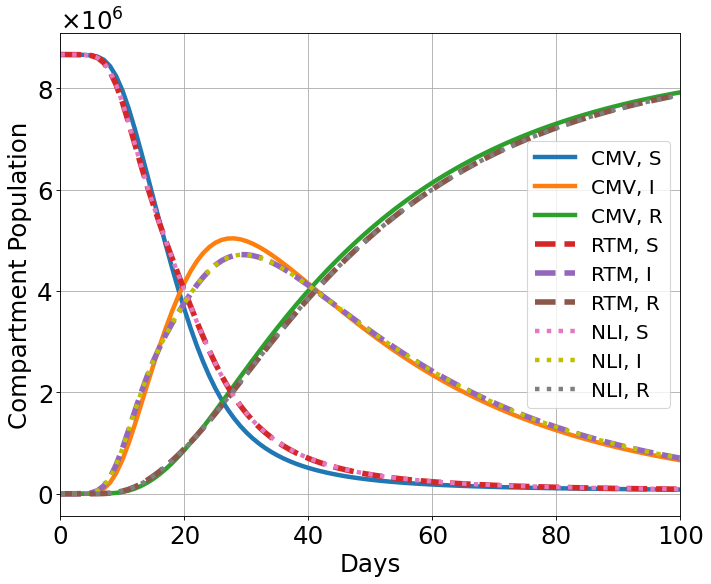

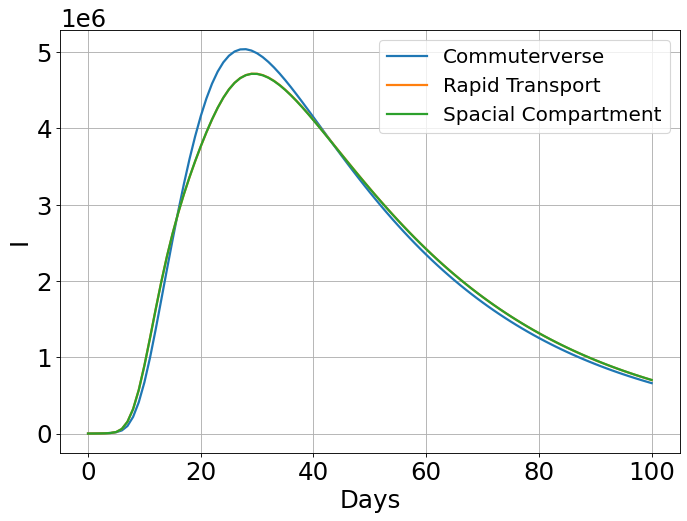

In [24]:
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nd):
    total_w += Nw[M][i]
    total_r += Nh[M][i]
print('Toatl', total_w, total_r)

S_total = []
I_total = []
for i in range(len(S_RTM[0])):
    S_total.append(0.0)
    I_total.append(0.0)
for i in range(M1):
    S_total  += S_RTM[i]
    I_total  += I_RTM[i]
    
S_total2 = []
I_total2 = []
for i in range(len(S_RTM[0])):
    S_total2.append(0.0)
    I_total2.append(0.0)
for i in range(M1):
    S_total2  += S_SCM[i]
    I_total2  += I_SCM[i]
plt.plot(ts_days, S, label="CMV, S", lw=4)
plt.plot(ts_days, I, label="CMV, I", lw=4)
plt.plot(ts_days, R, label="CMV, R", lw=4)

plt.plot(t/24, S_total, label='RTM, S', lw=5, linestyle='dashed')
plt.plot(t/24, I_total, label='RTM, I', lw=5, linestyle='dashed')
plt.plot(t/24, total_r - S_total - I_total, label='RTM, R', lw=5, linestyle='dashed')

plt.plot(t/24, S_total2, label='NLI, S', lw=4, linestyle='dotted')
plt.plot(t/24, I_total2, label='NLI, I', lw=4, linestyle='dotted', color='y')
plt.plot(t/24, total_r - S_total2 - I_total2, label='NLI, R', lw=4, linestyle='dotted')

plt.xlabel('Days')
plt.ylabel('Compartment Population')
plt.legend(fontsize=18); plt.grid() 
#plt.autoscale(enable=True, axis='x', tight=True)

ax=plt.subplot()
#ax.grid(which="both")
#ax.set_xlabel("x")
#ax.set_ylabel("y")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax.set_xlim([0,100])
#ax.set_ylim([0,2.0*10**1])
fig.savefig("London_EpidemicCurve-CVM-RTM-SCM.png")

f_data = open('network-SIR-MFT.txt', mode='w')
for i in range(len(t)):
    f_data.write(str(t[i]/24) + ' ' + str(S_total[i]) + ' ' + str(I_total[i]) + '\n')
f_data.close()

fig = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nd):
    total_w += Nw[M,i]
    total_r += Nh[M,i]
print('Toatl', total_w, total_r)

RTM_total = []
SCM_total = []
for i in range(len(S_SCM[0])):
    RTM_total.append(0.0)
    SCM_total.append(0.0)
for i in range(M1):
    RTM_total  += I_RTM[i]
    SCM_total  += I_SCM[i]

plt.plot(ts_days, I, label="Commuterverse", lw = 2)
plt.plot(t/24, RTM_total, '-', label='Rapid Transport', lw=2)
plt.plot(t/24, SCM_total, '-', label='Spacial Compartment', lw=2)
plt.legend(fontsize=18); plt.grid() 
plt.xlabel('Days')
plt.ylabel('I')
fig.savefig("London_I-CVM-RTM-SCM.png")

## Spacial distibution of S,I and R

In [25]:
import pickle
import tempfile
#import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
from matplotlib import animation

# Simulation data


N_ = np.zeros((len(t), Nd))
for tt in range(len(t)):
        for n in range(Nd):
            N_[tt, n] = Nh[M,n]

#Commuteverse 
S_CVM_ = np.sum(community_data[:,:,0,:], axis=1)
I_CVM_ = np.sum(community_data[:,:,1,:], axis=1)
R_CVM_ = np.sum(community_data[:,:,2,:], axis=1)

s_cvm_ = S_CVM_ / N_
i_cvm_ = I_CVM_ / N_
r_cvm_ = R_CVM_ / N_

#Rapid Transport
S_RTM_ = np.sum(rtm_community_data[:,:,0,:], axis=1)
I_RTM_ = np.sum(rtm_community_data[:,:,1,:], axis=1)
R_RTM_ = np.sum(rtm_community_data[:,:,2,:], axis=1)

s_rtm_ = S_RTM_ / N_
i_rtm_ = I_RTM_ / N_
r_rtm_ = R_RTM_ / N_

#Spacial Compartment
S_SCM_ = np.sum(scm_community_data[:,:,0,:], axis=1)
I_SCM_ = np.sum(scm_community_data[:,:,1,:], axis=1)
R_SCM_ = np.sum(scm_community_data[:,:,2,:], axis=1)

s_scm_ = S_SCM_ / N_
i_scm_ = I_SCM_ / N_
r_scm_ = R_SCM_ / N_

ts_days = t/24

# Load geometry

geometry_node_key = 'msoa11cd'
geometry = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")

loc_table = pd.read_csv('london_simulation/loc_table.csv')
loc_table_loc_col = loc_table.columns[0]
loc_table_loc_key_col = loc_table.columns[1]

geometry = geometry[ geometry[geometry_node_key].isin(loc_table.iloc[:,1]) ] # Remove locations in geometry that are not in loc_table
geometry = geometry.merge(loc_table, left_on=geometry_node_key, right_on=loc_table_loc_key_col) # Add location indices
geometry = geometry.sort_values(by=loc_table_loc_col) # Sort them by location indices

# Edit this function to adjust the layout of the video

def plot_frame(ti, close_plot=False, tmp_save=None):
    fig, axes = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios':[1, 1, 1.3]}, figsize=(18, 14))

    geometry['S'] = s_[ti,:]
    geometry['I'] = i_[ti,:]
    geometry['R'] = r_[ti,:]
    
    plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='S', title="Susceptible", legend=False)
    plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='I', title="Infected", legend=False)
    plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R', title="Recovered", legend=False)
    
    plot_epi(axes[1,2], ti, ts_days, epi_data, ['S','I','R'])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("SEAIR Model - Day %s" % ti, fontsize=18)
    
    if not tmp_save is None:
        plt.savefig(tmp_save.name + '/%s.png' % ti)
    if close_plot:
        plt.close(fig)
    if not tmp_save is None:
        return tmp_save.name + '/%s.png' % ti

# Helper functions for plotting

def plot_geo(geometry, ax, vmin, vmax, value_key='val', title="", legend=True, legend_label='', cax=None, axis_on=False):
    if legend:
        if cax is None:
            geometry.plot(column=value_key, ax=ax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
        else:
            geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
    else:
        geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=False)
        
    ax.set_title(title)
    if not axis_on:
        ax.set_axis_off()
        
def plot_epi(ax, ti, ts, epi_data, epi_data_labels):
    for oi in range(epi_data.shape[0]):
        ax.plot(ts[:ti], epi_data[oi,:ti], label=epi_data_labels[oi])
    ax.legend(loc='center left')
    
    ax.set_xlim(np.min(ts_days), np.max(ts_days))
    ax.set_ylim(0, np.max(epi_data))

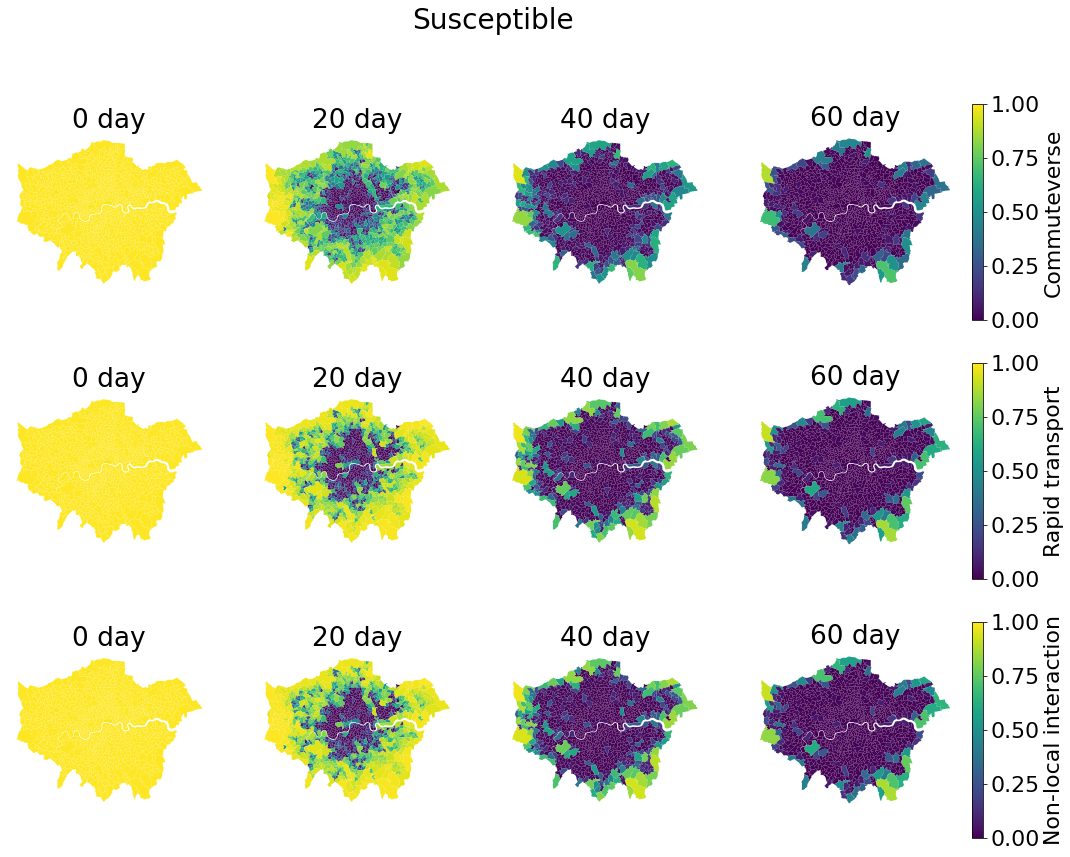

In [26]:
fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.28]}, figsize=(18, 13.5))

fig.suptitle('Susceptible', fontsize=28)

dday = 20

geometry['C0']  = s_cvm_[0*dday,:]
geometry['C10'] = s_cvm_[1*dday,:]
geometry['C20'] = s_cvm_[2*dday,:]
geometry['C30'] = s_cvm_[3*dday,:]

geometry['R0']  = s_rtm_[0*dday,:]
geometry['R10'] = s_rtm_[1*dday,:]
geometry['R20'] = s_rtm_[2*dday,:]
geometry['R30'] = s_rtm_[3*dday,:]

geometry['S0']  = s_scm_[0*dday,:]
geometry['S10'] = s_scm_[1*dday,:]
geometry['S20'] = s_scm_[2*dday,:]
geometry['S30'] = s_scm_[3*dday,:]

plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='C0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='C10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='C20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='C30', title='%s day' % (3*dday), legend=True, legend_label='Commuteverse')
plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='S0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='S10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2,2], vmin=0, vmax=1, value_key='S20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[2,3], vmin=0, vmax=1, value_key='S30', title='%s day' % (3*dday), legend=True, legend_label='Non-local interaction')
fig.savefig('Susceptible.png')

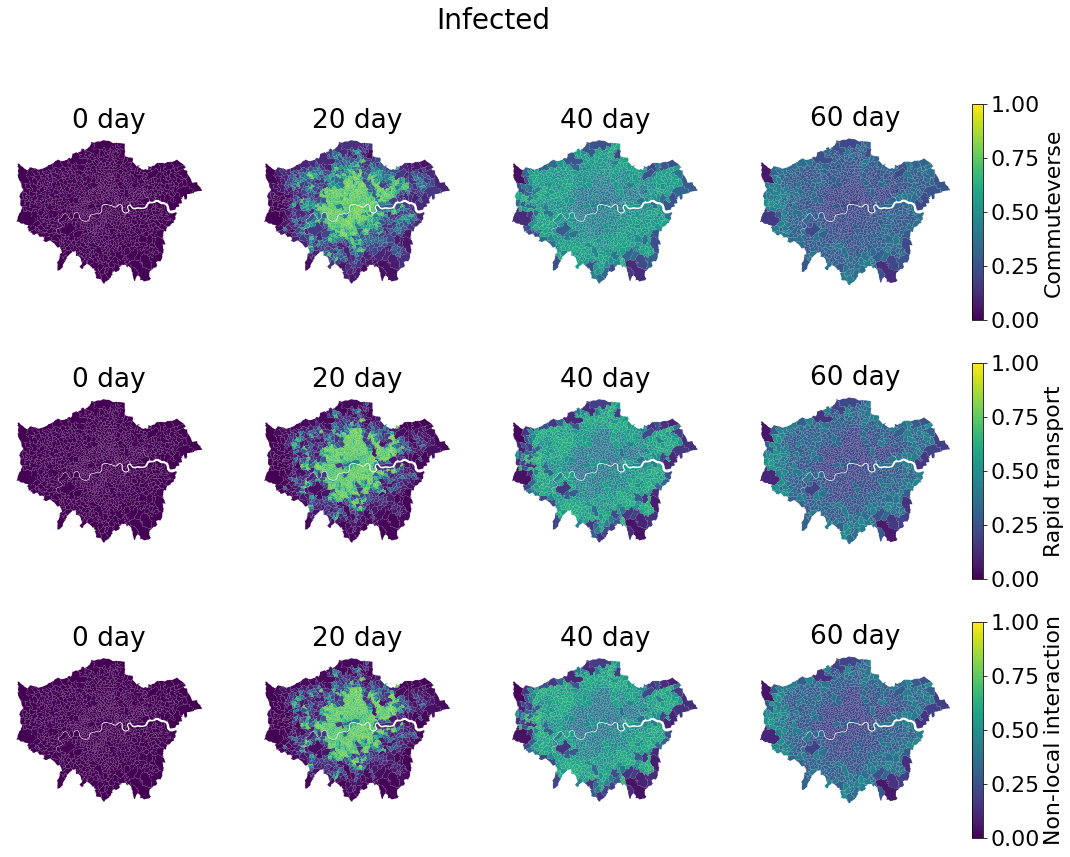

In [27]:
fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.28]}, figsize=(18, 13.5))

fig.suptitle('Infected', fontsize=28)

geometry['C0']  = i_cvm_[0*dday,:]
geometry['C10'] = i_cvm_[1*dday,:]
geometry['C20'] = i_cvm_[2*dday,:]
geometry['C30'] = i_cvm_[3*dday,:]

geometry['R0']  = i_rtm_[0*dday,:]
geometry['R10'] = i_rtm_[1*dday,:]
geometry['R20'] = i_rtm_[2*dday,:]
geometry['R30'] = i_rtm_[3*dday,:]

geometry['S0']  = i_scm_[0*dday,:]
geometry['S10'] = i_scm_[1*dday,:]
geometry['S20'] = i_scm_[2*dday,:]
geometry['S30'] = i_scm_[3*dday,:]

plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='C0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='C10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='C20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='C30', title='%s day' % (3*dday), legend=True, legend_label='Commuteverse')
plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='S0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='S10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2,2], vmin=0, vmax=1, value_key='S20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[2,3], vmin=0, vmax=1, value_key='S30', title='%s day' % (3*dday), legend=True, legend_label='Non-local interaction')
fig.savefig('Infection.png')

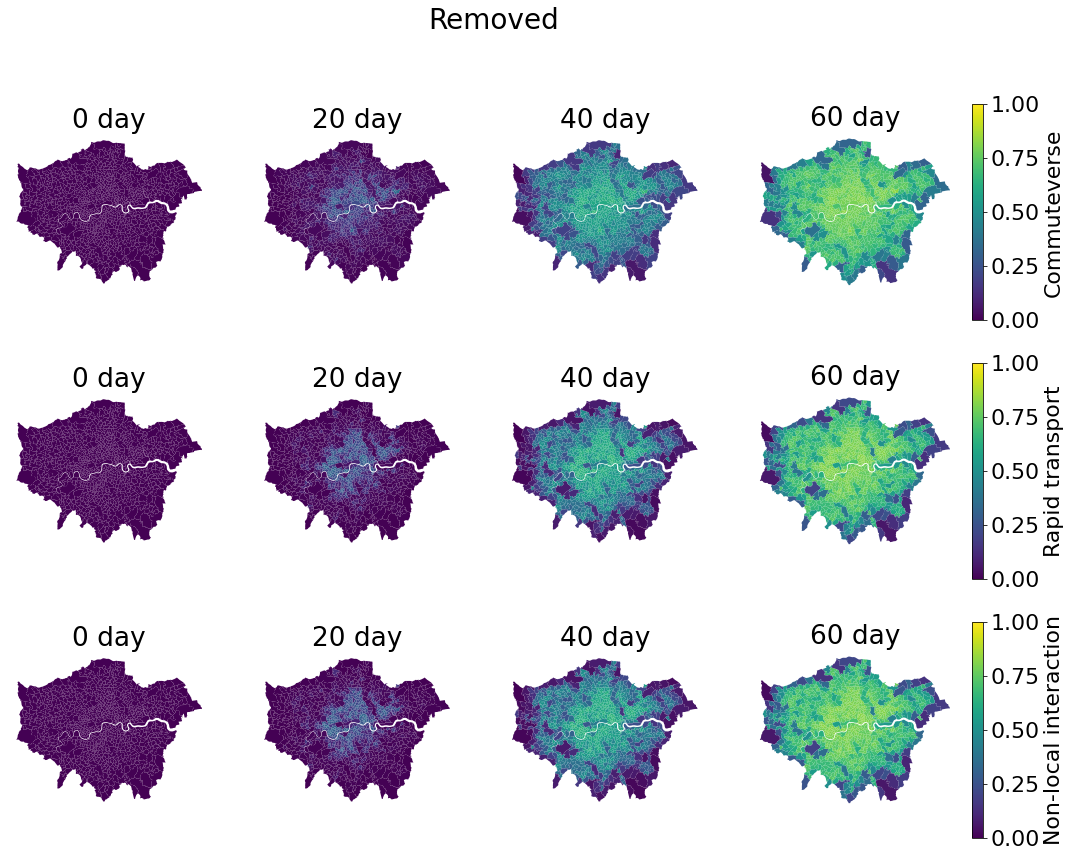

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=3, gridspec_kw={'width_ratios':[1, 1, 1, 1.28]}, figsize=(18, 13.5))

fig.suptitle('Removed', fontsize=28)

geometry['C0']  = r_cvm_[0*dday,:]
geometry['C10'] = r_cvm_[1*dday,:]
geometry['C20'] = r_cvm_[2*dday,:]
geometry['C30'] = r_cvm_[3*dday,:]

geometry['R0']  = r_rtm_[0*dday,:]
geometry['R10'] = r_rtm_[1*dday,:]
geometry['R20'] = r_rtm_[2*dday,:]
geometry['R30'] = r_rtm_[3*dday,:]

geometry['S0']  = r_scm_[0*dday,:]
geometry['S10'] = r_scm_[1*dday,:]
geometry['S20'] = r_scm_[2*dday,:]
geometry['S30'] = r_scm_[3*dday,:]

plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='C0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='C10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='C20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[0,3], vmin=0, vmax=1, value_key='C30', title='%s day' % (3*dday), legend=True, legend_label='Commuteverse')
plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[1,2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[1,3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
plot_geo(geometry, axes[2,0], vmin=0, vmax=1, value_key='S0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[2,1], vmin=0, vmax=1, value_key='S10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2,2], vmin=0, vmax=1, value_key='S20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[2,3], vmin=0, vmax=1, value_key='S30', title='%s day' % (3*dday), legend=True, legend_label='Non-local interaction')
fig.savefig('Removed.png')